# Exploring Kitti Dataset
This notebook is only to explore the Kitti dataset and get some useful information about it.

## Object Detection Evaluation 2012

![Object Detection Evaluation 2012 Dataset Sample](http://www.cvlibs.net/datasets/kitti/images/header_object.jpg)

The object detection and object orientation estimation benchmark consists of 7481 training images and 7518 test images, comprising a total of 80.256 labeled objects. All images are color and saved as png. For evaluation, we compute precision-recall curves for object detection and orientation-similarity-recall curves for joint object detection and orientation estimation. In the latter case not only the object 2D bounding box has to be located correctly, but also the orientation estimate in bird's eye view is evaluated. To rank the methods we compute average precision and average orientation similiarity. We require that all methods use the same parameter set for all test pairs. Our development kit provides details about the data format as well as MATLAB / C++ utility functions for reading and writing the label files.

In [1]:
absolute_path = "/home/data/Kitti/"
train_path = "data_object_image_2/training/image_2/"
test_path = "data_object_image_2/testing/image_2/"

fig_width = 12
fig_height = 9

# To import the picture
from scipy import misc

# To display the image
import matplotlib.pyplot as plt
%matplotlib inline

Kitti <br/>
&nbsp;&nbsp;&nbsp;↳ data_object_image_2 <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↳ testing <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↳ image_2 _(7518 img)_ <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↳ training <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↳ image_2 _(7481 img)_ <br/>
&nbsp;&nbsp;&nbsp;↳ data_object_label_2 <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↳ training <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↳ label_2 _(7481 txt)_ <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↳xml _(empty)_ <br/>
              <br/>
&nbsp;&nbsp;&nbsp;↳ label_test.txt _(images used for testing)_ <br/>
&nbsp;&nbsp;&nbsp;↳ label_train.txt _(images used for training)_ <br/>
&nbsp;&nbsp;&nbsp;↳ table-xml.el _()_ <br/>
&nbsp;&nbsp;&nbsp;↳ xml _(empty)_ <br/>

In [19]:
def create_im_path(im_id, im_set, db_absolute_path = absolute_path):
    """
    This function create the absolute path of an image
    
    Argument:
    im_id            -- int corresponding to the image id in the kitti dataset
    im_set           -- 'train' or 'test'
    db_absolute_path -- absolute path to the Kitti root folder
    
    Returns:
    im_path -- absolute path to the image
    """
    len_filename = 6
    
    im_filename = str(im_id).zfill(len_filename) + ".png"
    
    im_path = db_absolute_path + globals()[im_set +'_path'] + im_filename
    
    return im_path

In [34]:
def import_im(im_id, im_set, db_absolute_path = absolute_path):
    """
    This import the image in a numpy array
    
    Argument:
    im_id            -- int corresponding to the image id in the kitti dataset
    im_set           -- 'train' or 'test'
    db_absolute_path -- absolute path to the Kitti root folder
    
    Returns:
    im_path -- absolute path to the image
    """
    # Create file absolute path
    im_path = create_im_path(im_id, im_set, db_absolute_path)
    
    # Import the image
    im = misc.imread(im_path)
    
    return im

In [38]:
def diplay_im(im_id, im_set, db_absolute_path = absolute_path, im_width=fig_width, im_height=fig_height, im_axis='off'):
    """
    This function displays an image from its id
    
    Argument:
    im_id            -- int corresponding to the image id in the kitti dataset
    im_set           -- 'train' or 'test'
    db_absolute_path -- absolute path to the Kitti root folder
    im_width         -- width of the image to display
    im_height        -- height of the image to display
    im_axis          -- 'on' or 'off'
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    # Import the image 
    im = import_im(im_id, im_set, db_absolute_path)

    # TODO parameters to change size and to remove scale
    plt.figure(figsize=(im_width, im_height)) 
    plt.imshow(im)
    plt.axis(im_axis)
    plt.show()


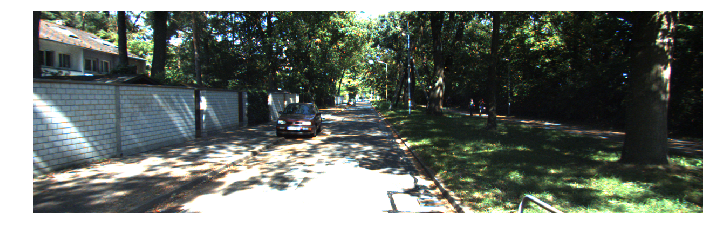

In [39]:
diplay_im("600", 'test')